In [1]:
%run ./PPS_Expansion_Model.ipynb

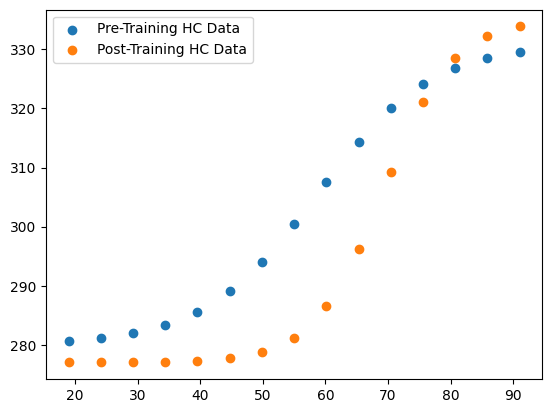

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 100 - 1.377 * v
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(a_distances, fprHCCP, fprHCS)
plt.scatter(a_distances, HC_RTs, label="Pre-Training HC Data")

##Post-Training
###Healthy Controls
ymin = 277
ymax = 335
fpostHCCP = 100 - 1.028 * v
fpostHCS = 1 / 0.18  # negative

HC_RTs_post = RTsig(a_distances, fpostHCCP, fpostHCS)
plt.scatter(a_distances, HC_RTs_post, label="Post-Training HC Data")
plt.legend()

In [4]:
from scipy.optimize import differential_evolution

HCLt, HCLa, HCLv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)

HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

k_a = 5e-05
k_v = 5e-05
stim_counts = 10
# locav_x = 60


def train_hcmodel(theta):
    rho_0 = theta[0]
    siga_x = theta[1]
    locav_x = theta[2]

    HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
        n_steps=stim_counts,
        T=simtime,
        ts=ts,
        Lt=HCLt,
        La=HCLa,
        Lv=HCLv,
        Wt=HCWt,
        Wa=HCWa,
        Wv=HCWv,
        Bt=HCBt,
        Ba=HCBa,
        Bv=HCBv,
        Wat=HCWat,
        Wvt=HCWvt,
        Wav=HCWav,
        FWpr=0,
        rho_0=rho_0,
        Wmax_a=6.5,
        Wmax_v=6.5,
        k_a=k_a,
        k_v=k_v,
        theta=0.05,
        siga_x=siga_x,
        sigv_x=0.03,
        locav_x=locav_x,
    )

    _, _, _, _, HCrtpost = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=HCLt,
        La=HCLa,
        Lv=HCLv,
        Wt=HCWt,
        Wa=HCWa_tr[:, :, -1, -1],
        Wv=HCWv_tr[:, :, -1, -1],
        Bt=HCBt,
        Ba=HCBa,
        Bv=HCBv,
        Wat=HCWat,
        Wvt=HCWvt,
        Wav=HCWav,
        FWpr=0,
        CMpr=0,
    )

    HC_Model_RTs_post = fit_RT(xf=HCrtpost, yf=HC_RTs_post)
    cost = np.sum(np.square(np.divide(HC_RTs_post - (HC_Model_RTs_post), HC_RTs_post)))

    return cost * 100000


bounds = [(0, 0.1), (0.3, 80), (20, 60)]
train_hcmodel_res = differential_evolution(
    train_hcmodel, bounds, disp=True, workers=30, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 49.36244570090476
differential_evolution step 2: f(x)= 49.36244570090476
differential_evolution step 3: f(x)= 49.36244570090476
differential_evolution step 4: f(x)= 42.270170630706666
differential_evolution step 5: f(x)= 42.270170630706666
differential_evolution step 6: f(x)= 42.270170630706666
differential_evolution step 7: f(x)= 42.270170630706666
differential_evolution step 8: f(x)= 42.270170630706666
differential_evolution step 9: f(x)= 35.38790743357556
differential_evolution step 10: f(x)= 35.38790743357556
differential_evolution step 11: f(x)= 29.594831831238327
differential_evolution step 12: f(x)= 29.594831831238327
differential_evolution step 13: f(x)= 29.594831831238327
differential_evolution step 14: f(x)= 29.594831831238327
differential_evolution step 15: f(x)= 29.594831831238327
differential_evolution step 16: f(x)= 29.594831831238327
differential_evolution step 17: f(x)= 29.594831831238327
differential_evolution step 18: f(x)= 29.5948

In [6]:
print(train_hcmodel_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 21.639191143653086
                   x: [ 2.029e-03  2.183e+01  3.180e+01]
                 nit: 56
                nfev: 2565
          population: [[ 2.029e-03  2.183e+01  3.180e+01]
                       [ 2.021e-03  2.157e+01  3.198e+01]
                       ...
                       [ 2.252e-03  2.170e+01  3.170e+01]
                       [ 2.351e-03  2.126e+01  3.193e+01]]
 population_energies: [ 2.164e+01  2.164e+01 ...  2.164e+01  2.164e+01]


In [18]:
## Fitted training model
k_a = 5e-05
k_v = 5e-05
stim_counts = 10
locav_x = 60

rho_0, siga_x, sigv_x = (
    1.129e-01,
    6.883e01,
    2.283e00,
)  # 9.959e-02, 6.873e+01, 5.788e-01  #9.526e-02, 6.846e01, 9.532e-01 for 70

HCLt, HCLa, HCLv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)

HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

HCWa_tr, HCWv_tr, zm, zv, za, zt = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=HCLt,
    La=HCLa,
    Lv=HCLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

Text(0.5, 1.0, 'HC')

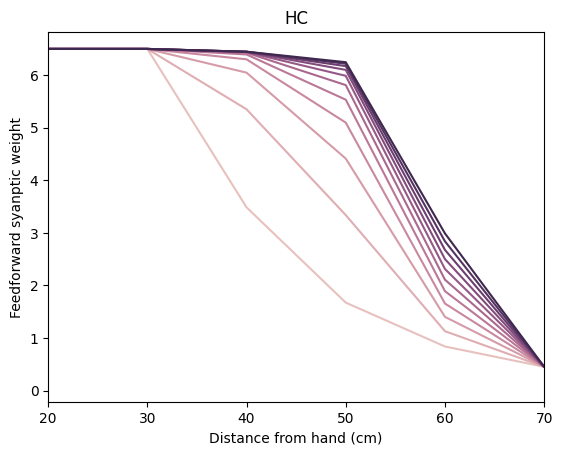

In [19]:
import seaborn as sns

hc_training_steps = np.column_stack((HCWa_tr[:, 1, :, 0], HCWa_tr[:, 1, -1, -1]))

sns.lineplot(
    hc_training_steps, palette="ch:dark=.20,light=.80", dashes=False, legend=False
)
plt.xlim(2, 7)
plt.xticks(ticks=[2, 3, 4, 5, 6, 7], labels=[20, 30, 40, 50, 60, 70])
plt.xlabel("Distance from hand (cm)")
plt.ylabel("Feedforward syanptic weight")
plt.title("HC")

In [20]:
_, _, _, _, HC_Model_RTs_post = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=HCLt,
    La=HCLa,
    Lv=HCLv,
    Wt=HCWt,
    Wa=HCWa_tr[:, :, -1, -1],
    Wv=HCWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

HC_Model_RTs_post_scaled = fit_RT(HC_Model_RTs_post, HC_RTs_post)

_, _, _, _, HC_Model_RTs_pre = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=HCLt,
    La=HCLa,
    Lv=HCLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

HC_RTs_model_pre_scaled = fit_RT(HC_Model_RTs_pre, HC_RTs)

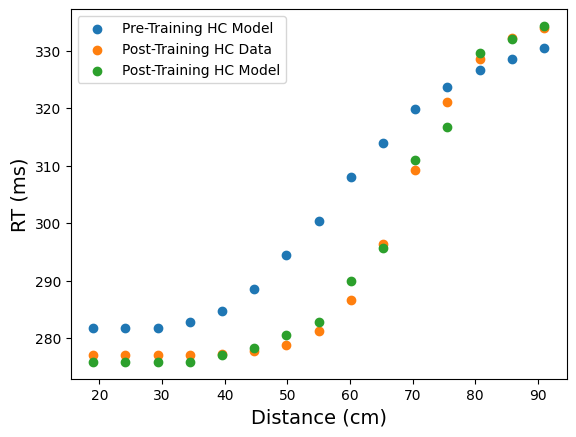

In [21]:
plt.scatter(a_distances, HC_RTs_model_pre_scaled, label="Pre-Training HC Model")
plt.scatter(a_distances, HC_RTs_post, label="Post-Training HC Data")
plt.scatter(a_distances, HC_Model_RTs_post_scaled, label="Post-Training HC Model")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()